# Anomaly Detection on DGraphFin Dataset

This notebook outlines variouse machine learning and deep learning methods for anomaly detection in the recently proposed finance dataset, [DGraphFin](https://dgraph.xinye.com/introduction). DGraphFin represents a collection of large-scale dynamic graph datasets, consisting of interactive objects, events and labels that evolve with time. 

The notebook is organized as follows:

1. [Environment Setup and Imports](#section1)


2. [DGraphFin Introduction](#section2)


3. [Anomaly Detection Pipline](#section3)
    
    3.1. [Loading Data](#section31)

    3.2. [Metrics](#section32)

    3.3. [Training / Loading Pre-Trained model](#section33)

    3.4. [Inference](#section34)
    

4. [Anomaly Detection Algorithms](#section4)

    4.1. [Tabular Methods](#section41)

    4.2. [Graph Methods](#section43)
    

5. [Results Comparision](#section5)


<a id='section1'></a>
## 1. Environment Setup and Imports

In this initial step, we begin by importing the necessary packages for our experiments. To ensure reproducibility, we set a **seed** value. Additionally, we establish the paths for loading saved models and storing results, which we define as **LOAD_PATH** and **RESULT_PATH**, respectively.

In [15]:
# import the necessary package
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

import warnings
warnings.filterwarnings("ignore")

from Dataset.prepare_data import DataGenerator
from myutils import Utils

seed = 20
LOAD_PATH = '/ssd003/projects/aieng/public/anomaly_detection_models/DGraphFin/checkpoints/Global_results/'
RESULTS_PATH = '/ssd003/projects/aieng/public/anomaly_detection_models/DGraphFin/results/Global_results/'


<a id='section2'></a>
## 2. DGraphFin Introduction

DGraphFin is a **new large scale graph dataset** introduced in NeurIPS 2022 conference and sourced from real-world finance scenarios, specifically focused on fraud detection. It is derived from the raw data provided by Finvolution Group3, a leading player in China's online consumer finance industry. The raw data for a specific user includes five components:

- User ID.
- Basic personal profile information, such as age, gender, etc.
- Telephone number; note that each account is matched with a specific telephone number.
- Borrowing behavior, which includes the repayment due date and the actual repayment date.
- Emergency contacts, which include the name, telephone number, and last updating time for each contact.

Although providing basic personal information is optional, providing emergency contact information is necessary to be eligible to borrow money. All raw data is processed through data masking to strictly respect and protect the privacy of users. 

**Anomalous users** are individuals who exhibit overdue behaviors, indicating a failure to fulfill financial obligations on time. These users often provide false personal information, have unusual social networks, and display abnormal behavior as platform operators. The emergency contact information is considered a special connection among users as it reveals the social network of the users. By constructing DGraphFin, a graph based on user profiles and emergency contact links, it becomes possible to identify and detect anomalous users.

Graph structure:
- Each **node** represents a user with a **17-dimensional feature vector** derived from their personal information and missing values in the feature vector are represented with '-1'.
- An **edge** from one user to another signifies that the user regards the other as their emergency contact.

DGraphFin provides **3M total nodes** as users in a graph with
- **1M ground-truth nodes** referring to users who borrowd money. Only **1.3%** of the nodes are anomalous.
- **2M background nodes** referring to users who are not detection targets due to a lack of borrowing behavior.

The demographic represntation of this dataset can be observed in the following figure:


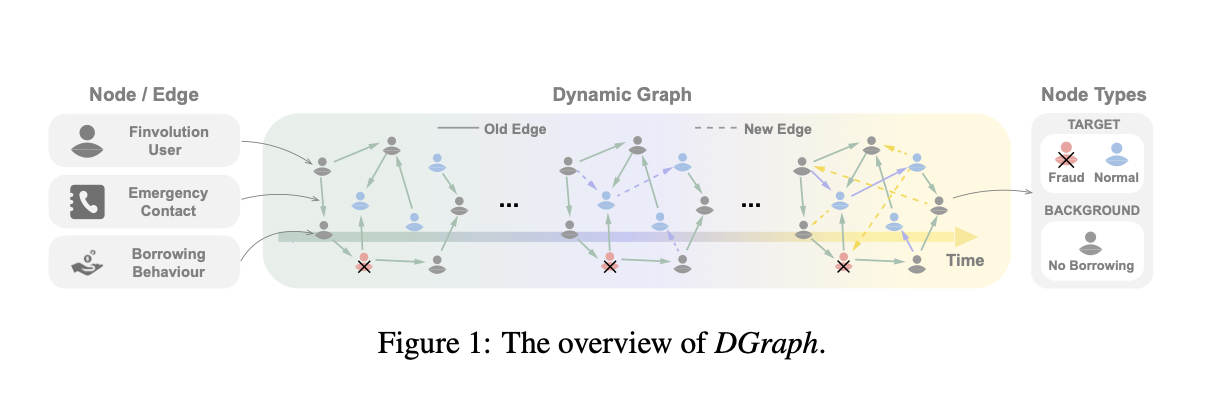

<a id='section3'></a>
## 3. Anomaly Detection Pipeline

Before diving into introducing methods in more detail and conducting experiments, we first define a general pipeline for anomaly detection to enable effective comparisons between different methods.

DGraphFin is a graph dataset, but it can be easily converted into a tabular dataset by using only the node features as input. Therefore, we will study both state-of-the-art unsupervised and supervised anomaly detection methods on this dataset, considering both tabular and graph approaches.

Labeling anomalies can be costly and time-consuming. To study the effect of available labeled anomalies on the performance of each method, we will conduct a series of experiments with a determined ratio of available labeled anomalies from the provided 1M ground truth nodes. For example, if the ratio of anomalies is 0.1, it means we assume only 0.1 of the data is labeled, while the remaining 0.9 is not labeled. Thus, we will only use 0.1 of the labeled anomalous samples as anomalies, considering the rest as normal samples.

`'clf_dictionary':` contains a list of methods that we will study, divided into their respective groups.

`'rla_list':` contains a list of anomaly ratios for which we will study each method.

In [2]:
clf_dictonary = {'Tabular': {
                     'Unsupervised':['IForest','CBLOF'],
                     'Supervised':['DeepSAD','MLP','FTTransformer','XGB']},
                 'Graph': {
                     'Unsupervised':['OCGNN', 'DONE','AdONE'],
                     'Supervised':['GCN', 'SAGE','AMNet']}}

rla_list = [0.0,0.01,0.05,0.1,0.25,0.5,0.75,1.0]

<a id='section31'></a>
### 3.1. Loading Data

First, we define the **load_data** function, which generate the data used for training and testing in the pipeline.

`'load_data':` function takes **rla** as the ratio of labeled and loads data using the **DataGenerator** class. **DataGenerator** class has the initialization parameters **seed** and **dataset_name** for setting the seed and the name of the dataset, respectively. This class also includes the **graph_generator** function, which takes **rla** as the ratio of labeled anomalies and makes the **DGraphFin** dataset. It modifies original labels of dataset based on required ratio of anmalies and returns an instance of the **PyG Data** class, which contains the following:

- `'x':` A 17-dimensional feature vectors of nodes.
- `'y':` Labels with four classes [0, 1, 2, 3], where 0 represents normal users, 1 represents anomalous users, and 2 and 3 represent background nodes.
- `'train_mask', 'valid_mask', 'test_mask':` Masks for the train, validation, and test sets, respectively.
- `'edge_index':` Edge indices which each row contains two numbers showing first user puts the second user as its emergency contact.
- `'edge_attr':` Edge features.
<!-- 'num_nodes' is the number of nodes in the graph and 'num_classes' is the number of classes in the dataset. -->

In [3]:
def load_data(rla:int=1.0):
    '''
        :param rla: ratio of labeled anomalies, can be either the ratio of labeled anomalies or the number of labeled anomalies
    '''
    datagenerator = DataGenerator(seed=seed, dataset_name="DgraphFin") # data generator
    return datagenerator.graph_generator(rla=rla) # only 10% labeled anomalies are available

In [4]:
load_data(rla=0.01)

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.01}




Data(x=[3700550, 17], edge_index=[2, 4300999], edge_attr=[4300999], y=[3700550], train_mask=[857899], valid_mask=[183862], test_mask=[183840])

<a id='section32'></a>
### 3.2. Metrics

Here we define **df_AUCROC, df_AUCPR, df_time_fit and df_time_inference** dataframes to save results of methods in terms of type and supervision in a separate dataframe and in each datafram we will save the results of methods in respective group using different ratio of labeled anomalies.

`'df_AUCROC':` contains [AUCROC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) metric which computes the area under the receiver operating characteristic (ROC) curve.
- **ROC curve** is a plot of the true positive rate (TPR) against the false positive rate (FPR) for the different possible anomaly threshold of. 
- **AUCROC** contain values between 0 and 1 and a model with a value of 1 is considered a perfect model, indicating that it can perfectly distinguish between all positive and negative classes by choosing an appropriate threshold.


`'df_AUCPR':` contains [AUCPR](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/performance-and-prediction.html?highlight=AUC#aucpr-area-under-the-precision-recall-curve) metric which computes the area under the precision-recall curve. 
- **Percision** mean how well our algorithm identifies *only anomalies*. 
- **Recall** means how well we identify *all anomalies*. 
- **AUCPR** values are obtained using different thresholds on a probabilistic or other continuous-output classifier. A model with value of 1 is considered a perfect model, indicating that it can perfectly distinguish only anomalies and distinguished anomalies are all anomalies.

**Comparision among AUCROC and AUCPR?** 
- Receiver Operator Characteristic (ROC) curves are commonly used to present results for binary decision problems in machine learning. However, when dealing with highly skewed datasets, Precision-Recall (PR) curves give a more informative picture of an algorithm’s performance.  
- Extremly lower AUCPR comparing to AUCROC indicates model tends to raise false positive rate compare to true positive rate and there are so many normal samples that are classified as anomalies.
<!-- - There is deep connection exists between ROC space and PR space, such that a curve dominates in ROC space if and only if it dominates in PR space. -->

`'df_time_fit':` containes the time required to train model over train data. 

`'df_time_inference':` containes the time required to test model over test data. 

`'Utils':` class contains various functions needed for pipeline including **metric** function which computes AUCROC and AUCPR.

In [5]:

df_AUCROC = {'Tabular': {'Unsupervised':{},'Supervised':{}},'Graph': {'Unsupervised':{},'Supervised':{}}}
df_AUCPR = {'Tabular': {'Unsupervised':{},'Supervised':{}},'Graph': {'Unsupervised':{},'Supervised':{}}}
df_time_fit = {'Tabular': {'Unsupervised':{},'Supervised':{}},'Graph': {'Unsupervised':{},'Supervised':{}}}
df_time_inference = {'Tabular': {'Unsupervised':{},'Supervised':{}},'Graph': {'Unsupervised':{},'Supervised':{}}}
for type_model in ('Tabular','Graph'):
    for supervision in ('Unsupervised','Supervised'):
        df_AUCROC[type_model][supervision] = pd.DataFrame(data=None, index= rla_list, columns=list(clf_dictonary[type_model][supervision]))
        df_AUCPR[type_model][supervision] = pd.DataFrame(data=None, index= rla_list, columns=list(clf_dictonary[type_model][supervision]))
        df_time_fit[type_model][supervision] = pd.DataFrame(data=None, index= rla_list, columns=list(clf_dictonary[type_model][supervision]))
        df_time_inference[type_model][supervision] = pd.DataFrame(data=None, index= rla_list, columns=list(clf_dictonary[type_model][supervision]))
utils = Utils() # utils function

<a id='section33'></a>
### 3.3. Training / Loading Pre-Trained model

Next, we define the **train_model** function, which is used to train a model, and the **load_pretrained_model** function, which is used to load the weights of a pretrained model instead of learning from scratch.

`'train_model':` function takes the data, the ratio of labeled anomalies in the dataset, the classifier, its type, the supervision, and the name as inputs. It returns the trained model and also computes the time required to train the model, which is saved in the **df_time_fit** dataframe. 

The training process is performed by calling the **fit** function of each classifier. For graph-based methods, the entire graph data is passed as **data**, and the training data indexes are passed as **indexes**. For tabular methods, only the node features are used as **X_train**, and the respective labels are used as **y_train**.

`'load_pretrained_model':` function also takes the data, the ratio of labeled anomalies in the dataset, the classifier, its type, the supervision, and the name as inputs. However, instead of training the model, it loads the pretrained model using the **load_model** function specific to each classifier.  The output of the **load_pretrained_model** function is also a trained model, which can be used interchangeably with the **train_model** function if we don't want to train the model from scratch. 

Each classifier's **load_model** function takes the path of the saved model or model weights as **path_load** and the entire graph data as **data**.


In [6]:
def train_model(data:object, rla:int, clf:object, type_model:str, supervision:str, model_name:str):
    '''
        :param data: graph data generated by load_data function
        :param rla: ratio of labeled anomalies, can be either the ratio of labeled anomalies or the number of labeled anomalies
        :param clf: classifier used to perform anomaly detection
        :param type_model: 'Tabular' or 'Graph'
        :param supervision: 'Unsupervised' or 'Supervised'
        :param model_name: name of the classifier
    '''

    # fitting
    start_time = time.time()
    if type_model == 'Graph':
        clf = clf.fit(data=data, indexes=data.train_mask)
    else:
        clf = clf.fit(X_train=data.x[data.train_mask], y_train=data.y[data.train_mask])
        
    end_time = time.time(); time_fit = end_time - start_time
    df_time_fit[type_model][supervision][model_name].loc[rla] = time_fit
    print(f"Time fit: {time_fit}")
    
    return clf


In [7]:
### Sample training model call
# train(data = data, rla = 0.01, clf = clf, type_model='Tabular', supervision='Supervised', model_name='MLP')

In [8]:
def load_pretrained_model(data , rla, clf, type_model, supervision, model_name):
    '''
        :param data: graph data generated by load_data function
        :param rla: ratio of labeled anomalies, can be either the ratio of labeled anomalies or the number of labeled anomalies
        :param clf: classifier used to perform anomaly detection
        :param type_model: 'Tabular' or 'Graph'
        :param supervision: 'Unsupervised' or 'Supervised'
        :param model_name: name of the classifier
    '''

    path_load = LOAD_PATH + type_model+'_'+supervision+'_seed_'+str(seed)+'_la_'+str(rla)+'_model_'+model_name
    
    # loading
    clf.load_model(path_load, data)
    
    return clf

In [9]:

### Sample loading pretrained model call
# load(rla = 0.01, clf = clf, type_model='Tabular', supervision='Supervised', model_name='MLP')

<a id='section34'></a>
### 3.4. Inference

Finally, we define the **test_model** function, which is used to predict the labels of the test set.

`'test_model':` function takes the data, the ratio of labeled anomalies in the dataset, the classifier, its type, the supervision, and the name as inputs. It computes the time required to perform the testing, as well as the AUCROC and AUCPR scores over the test data. These scores are saved in the **df_AUCROC**, **df_AUCPR**, and **df_time_inference** dataframes, respectively. 

To calculate the AUCROC and AUCPR scores, the **metric** function in the **Utils** class is used. This function takes the ground truth labels as **y_true** and the predicted scores as **y_score**. The predicted scores for the test data are obtained using the 'predict_score' function specific to each classifier. In graph-based methods, the entire graph data is passed as **data**, and the test data indexes are passed as **indexes**. In tabular methods, only the node features are used as **X_test**.



In [10]:
def test_model(data, rla, clf, type_model, supervision, model_name):
    '''
        :param data: graph data generated by load_data function
        :param rla: ratio of labeled anomalies, can be either the ratio of labeled anomalies or the number of labeled anomalies
        :param clf: classifier used to perform anomaly detection
        :param type_model: 'Tabular' or 'Graph' model
        :param supervision: 'Unsupervised' or 'Supervised' training
        :param model_name: name of the classifier
    '''
    
    # inference
    start_time = time.time()
    if type_model == 'Graph':
        score_test = clf.predict_score(data, data.test_mask)
    else:
        score_test = clf.predict_score(data.x[data.test_mask])
    end_time = time.time(); time_inference = end_time - start_time

    # performance
    result = utils.metric(y_true=data.y[data.test_mask].cpu(), y_score=score_test)
    df_AUCROC[type_model][supervision][model_name].loc[rla] = result['aucroc']
    df_AUCPR[type_model][supervision][model_name].loc[rla]= result['aucpr']
    df_time_inference[type_model][supervision][model_name].loc[rla] = time_inference
    print(f"Model: {model_name}, AUC-ROC: {result['aucroc']}, AUC-PR: {result['aucpr']}")
    print(f"Time inference:{time_inference}")
    

In [11]:
### Sample test model call  
# test(data = data, rla = 0.01, clf = clf, type_model='Tabular', supervision='Supervised', model_name='MLP')

<a id='section4'></a>
## 4. Anomaly Detection Algorithms


In this section, we will provide a more in detailed description of anomaly detection algorithms and conduct experiments on each algorithm using the pipeline described in the previous section.

For each method, we will begin by specifying the name of the method as **model_name**. Then, we will import the specific classifier class and save it as **clf**. Additionally, we will iterate over the **rla_list** to specify the ratio of labeled anomalies as **rla**. Sequentially, we will call the **load_data**, **train_model**/**load_pretrained_model**, and **test_model** functions in the given setting. In each algorithm you can uncomment the **train_model** function to train the model from scratch or you can use the **load_pretrained_model** function to load the pretrained model.

It is important to note that in unsupervised methods, we will perform experiments with a ratio of labeled anomalies (rla) set to '0', as these methods do not require labels for training. On the other hand, in supervised methods, we will conduct experiments with the remaining ratios of labeled anomalies, excluding '0', as these methods rely on labeled data for training.



<a id='section41'></a>
### 4.1. Tabular Methods

To evaluate state-of-the-art tabular algorithms' performance on the DGraphFin datase, we have incorporated the DGraphFin dataset into the [ADBench](https://github.com/Minqi824/ADBench) repository. ADBench is a comprehensive benchmark for tabular anomaly detection. It includes a study of 30 algorithms across 57 benchmark datasets. Based on the results of ADBench, we have selected the top 2 unsupervised and top 4 supervised methods.

#### 4.1.1. Unsupservised Methods

**[iForest]()** 
- iForest detects anomalies based on the theory that anomalies are data points that are few and different, thus are more susceptible to isolation than normal data points.
- Isolation Forest isolates anomalies by employing the following steps:
    - Randomly selecting a feature from the dataset.
    - Randomly selecting a split value between the maximum and minimum values of the selected feature.
    - Constructing multiple isolation trees (iTree).
- iTree is a binary search tree where each node in the tree has exactly zero or two child nodes.
- Anomaly scores are computed by averaging the length of the root to each sample on all iTrees.
- This method provides a measure of how easily an instance can be isolated, with higher scores indicating higher anomaly likelihood.


In [ ]:
from Baselines.TabularUnsupervised.run import PYOD

model_name = 'IForest'
clf = PYOD
clf = clf(seed=seed, model_name=model_name)

for rla in rla_list[0:1]:
    data = load_data(rla)

### Uncomment to train from scratch
#     train_model(data = data, rla = rla, clf = clf,  type_model='Tabular', supervision='Unsupervised', model_name='IForest')
    load_pretrained_model(data = data, rla = rla, clf = clf, type_model='Tabular', supervision='Unsupervised', model_name='IForest')
    test_model(data = data, rla = rla, clf = clf, type_model='Tabular', supervision='Unsupervised', model_name='IForest')
    print('------------------------------------------------------------------------------------------','\n')

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.0}


Model: IForest, AUC-ROC: 0.528719479115904, AUC-PR: 0.014227500800654555
Time inference:6.034763813018799
------------------------------------------------------------------------------------------ 



**[CBLOF]()**
- CBLOF operator calculates the outlier score based on cluster-based local outlier factor and assumes that anomalies are located in sparse regions that are far away from the dense clusters.
- It requires the input of a dataset and a cluster model generated by a clustering algorithm (kMeans) and classifies clusters into small clusters and large clusters using parameters alpha and beta.
- The anomaly score is calculated based on the size of the cluster the data point belongs to and its distance to the nearest large cluster.

In [ ]:
from Baselines.TabularUnsupervised.run import PYOD

model_name = 'CBLOF'
clf = PYOD
clf = clf(seed=seed, model_name=model_name)

for rla in rla_list[0:1]:
    data = load_data(rla)

### Uncomment to train from scratch
#     train_model(data = data, rla = rla, clf = clf, type_model='Tabular', supervision='Unsupervised', model_name='CBLOF')
    load_pretrained_model(data = data, rla = rla, clf = clf, type_model='Tabular', supervision='Unsupervised', model_name='CBLOF')
    test_model(data = data, rla = rla, clf = clf, type_model='Tabular', supervision='Unsupervised', model_name='CBLOF')
    print('------------------------------------------------------------------------------------------','\n')

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.0}


Model: CBLOF, AUC-ROC: 0.37880478457914946, AUC-PR: 0.009462969540342927
Time inference:2.321065664291382
------------------------------------------------------------------------------------------ 



#### 4.1.2. Supervised Methods

**[DeepSAD]()** 
- DeepSAD is a deep one-class method that improves the unsupervised DeepSVDD (Deep Support Vector Data Description) approach.
- DeepSVDD is training technique for deep networks that aims to minimize the volume of a hypersphere encompassing the network representations of the data.
- It performs a pretraining using autoencoder and then trains only encoder of network using the hypersphere loss.
- DeepSAD adds up to DeepSVDD this by penalizing the inverse of the distances of anomaly representation and anomalies are thus encouraged to be mapped further away from the hypersphere center.
- DeepSAD is utilized for anomaly detection by calculating the distance from the center of the learned hypersphere.

In [ ]:
from Baselines.TabularSupervised.DeepSAD.run import DeepSAD

model_name = 'DeepSAD'
clf = DeepSAD
clf = clf(seed=seed, model_name=model_name)

for rla in rla_list[1:]:
    data = load_data(rla)

### Uncomment to train from scratch
#     train_model(data = data, rla = rla, clf = clf, type_model='Tabular', supervision='Supervised', model_name='DeepSAD')
    load_pretrained_model(data= data, rla = rla, clf = clf,type_model='Tabular', supervision='Supervised', model_name='DeepSAD')
    test_model(data = data, rla = rla, clf = clf, type_model='Tabular', supervision='Supervised', model_name='DeepSAD')
    print('------------------------------------------------------------------------------------------','\n')

number of gpu: 1
cuda name: Tesla T4
GPU is on
cuda:0


{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.01}


Model: DeepSAD, AUC-ROC: 0.671502949477468, AUC-PR: 0.019892909600789807
Time inference:4.053292751312256
------------------------------------------------------------------------------------------ 

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.05}


Model: DeepSAD, AUC-ROC: 0.7043596799655627, AUC-PR: 0.024439850179268564
Time inference:3.0534286499023438
------------------------------------------------------------------------------------------ 

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ra

**[Deep CNN]()** 
- Deep Convolutional Neural Networks (CNN) models such as MLP and Transformers are also evaluated on the DGraphFin dataset in addition to deep anomaly detection methods.
- This evaluation allows us to explore the effectiveness of Deep CNN models in detecting anomalies in the DGraphFin dataset.

In [ ]:
from Baselines.TabularSupervised.DeepCNN.run import DeepCNN

model_name = 'MLP'
clf = DeepCNN
clf = clf(seed=seed, model_name=model_name)

for rla in rla_list[1:]:
    data = load_data(rla)

### Uncomment to train from scratch
#     train_model(data = data, rla = rla, clf = clf, type_model='Tabular', supervision='Supervised', model_name='MLP')
    load_pretrained_model(data= data, rla = rla, clf = clf, type_model='Tabular', supervision='Supervised', model_name='MLP')
    test_model(data = data, rla = rla, clf = clf, type_model='Tabular', supervision='Supervised', model_name='MLP')
    print('------------------------------------------------------------------------------------------','\n')

number of gpu: 1
cuda name: Tesla T4
GPU is on
cuda:0
{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.01}


Model: MLP, AUC-ROC: 0.657434618124721, AUC-PR: 0.01814991612837973
Time inference:0.7950577735900879
------------------------------------------------------------------------------------------ 

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.05}


Model: MLP, AUC-ROC: 0.7004116024544144, AUC-PR: 0.02269378476435564
Time inference:0.7904837131500244
------------------------------------------------------------------------------------------ 

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.

In [ ]:
from Baselines.TabularSupervised.DeepCNN.run import DeepCNN

model_name = 'FTTransformer'
clf = DeepCNN
clf = clf(seed=seed, model_name=model_name)

for rla in rla_list[1:]:
    data = load_data(rla)
    
### Uncomment to train from scratch
#     train_model(data = data, rla = rla, clf = clf,type_model='Tabular', supervision='Supervised', model_name='FTTransformer')
    load_pretrained_model(data= data, rla = rla, clf = clf,type_model='Tabular', supervision='Supervised', model_name='FTTransformer')
    test_model(data = data, rla = rla, clf = clf, type_model='Tabular', supervision='Supervised', model_name='FTTransformer')
    print('------------------------------------------------------------------------------------------','\n')

number of gpu: 1
cuda name: Tesla T4
GPU is on
cuda:0
{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.01}


Model: FTTransformer, AUC-ROC: 0.6828691804656603, AUC-PR: 0.020383548127547918
Time inference:13.265684127807617
------------------------------------------------------------------------------------------ 

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.05}


Model: FTTransformer, AUC-ROC: 0.6875116348455781, AUC-PR: 0.02035382625154561
Time inference:13.239688873291016
------------------------------------------------------------------------------------------ 

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled A

**[XGB]()** 
- XGBoost is an optimized distributed gradient boosting method and has become a popular choice in various machine learning tasks due to its superior performance.
- It is based on decision tree ensemble learning.
- It is specifically designed to be highly efficient, flexible, and portable.

In [ ]:
from Baselines.TabularSupervised.XGBoost.run import XGBoost

model_name = 'XGB'
clf = XGBoost
clf = clf(seed=seed, model_name=model_name)

for rla in rla_list[1:]:
    data = load_data(rla)

### Uncomment to train from scratch
#     train_model(data = data, rla = rla, clf = clf,type_model='Tabular', supervision='Supervised', model_name='XGB')
    load_pretrained_model(data = data, rla = rla, clf = clf,type_model='Tabular', supervision='Supervised', model_name='XGB')
    test_model(data = data, rla = rla, clf = clf,type_model='Tabular', supervision='Supervised', model_name='XGB')
    print('------------------------------------------------------------------------------------------','\n')

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.01}


Model: XGB, AUC-ROC: 0.7091245533614365, AUC-PR: 0.023822923788435115
Time inference:0.23503637313842773
------------------------------------------------------------------------------------------ 

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.05}




<a id='section42'></a>
### 4.2. Graph Methods

For unsupervised graph methods we used 3 methods from [PyGOD](https://github.com/pygod-team/pygod/) benchmark repository and modified it to support DGraphFin large scale dataset. For supervised methods we used implemented 2 baseline graph neural networks for classification and a specific graph anomaly detection method [AMNet](https://github.com/zjunet/AMNet) from their own provided repository.

#### 4.2.1. Unsupervised Methods

**[OCGNN]()**
- OCGNN (One Class Graph Neural Network) is a generalization of DeepSVDD specifically designed for graph networks.
- OCGNN takes into account both node features and graph relations to leverage the volume of a data-enclosing hypersphere in the output space around a certain point as center.
- It replaces the simple MLP with GCN (Graph Convolutional Network).

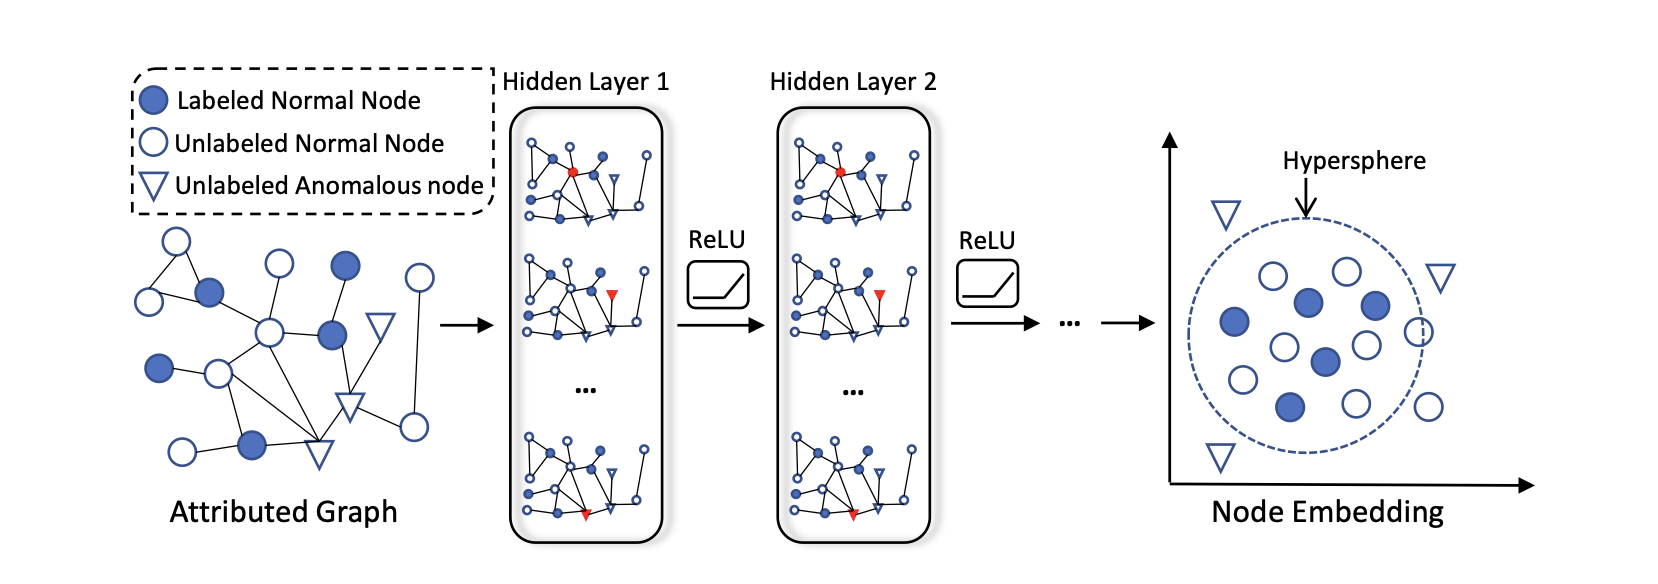

- Training algorithm of OCGNN is as follows:

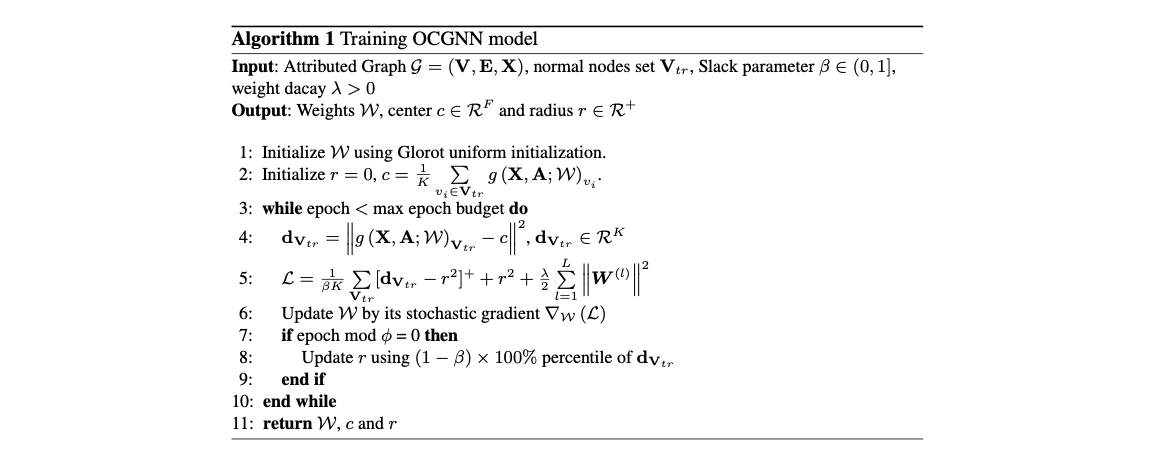


- As it does not pretraing the network and trains GCN from scratch using the hypersphere loss, it keeps updating the radious of hypersphere during training.
- The anomaly scores are computed based on their distance from the center.

In [9]:
from Baselines.GraphUnsupervised.run import PYGOD

model_name = 'OCGNN'
clf = PYGOD
clf = clf(seed=seed, model_name=model_name)

for rla in rla_list[0:1]:
    data = load_data(rla)

### Uncomment to train from scratch
#     train_model(data = data, rla = rla, clf = clf, type_model='Graph', supervision='Unsupervised', model_name='OCGNN')
    load_pretrained_model(data = data, rla = rla, clf = clf,type_model='Graph', supervision='Unsupervised', model_name='OCGNN')
    test_model(data = data, rla = rla, clf = clf,type_model='Graph', supervision='Unsupervised', model_name='OCGNN')
    print('------------------------------------------------------------------------------------------','\n')

number of gpu: 1
cuda name: Tesla T4
GPU is on
{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.0}


Model: OCGNN, AUC-ROC: 0.5266030978037779, AUC-PR: 0.021139910276643345
Time inference:71.97306275367737
------------------------------------------------------------------------------------------ 



**[DONE and AdONE]()** 
- DONE and AdONE are both an anomaly detection method that utilizes parallel autoencoders for both graph structure and node attributes, represented in below figure.
- They aim to minimize the impact of outlier nodes while generating network embeddings.

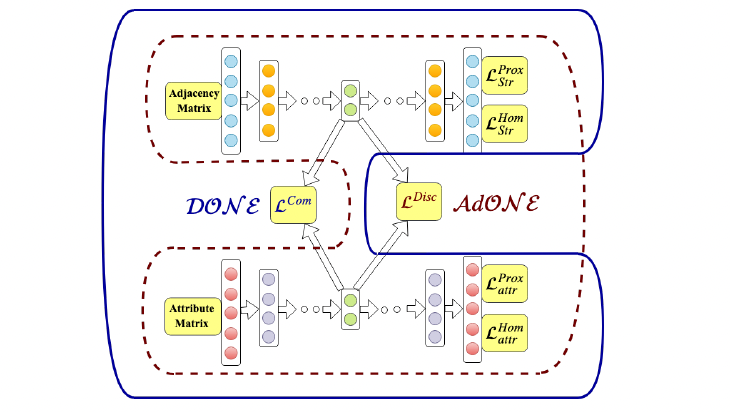

- They achieves this by minimizing the reconstruction error of each node's attributes and graph structure as $L^{Prox}_{str}$ and $L^{Prox}_{attr}$.
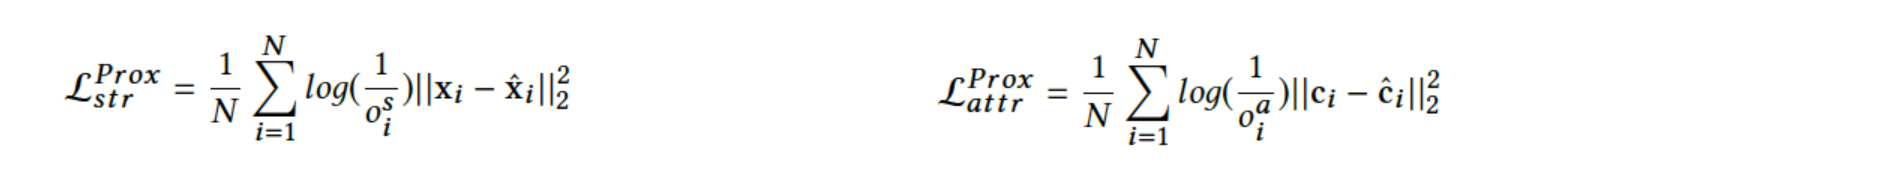

- They also minimize the distance between all of the constructed nodes attributes and adjacency matrix in the both autoencoders as $L^{Hom}_{str}$ and $L^{Hom}_{attr}$.
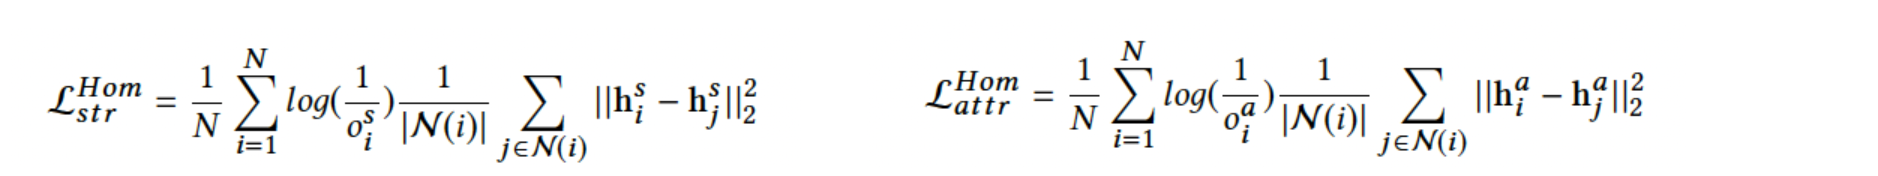

- While, DONE minimizes the distance between the latent representations of a node's attributes and adjacency matrix in the graph structure autoencoder as $L^{Com}$, AdONE addverserially train a discrimenator to not be able to discremenate between both latent representations of a node as $L^{Alg}$.
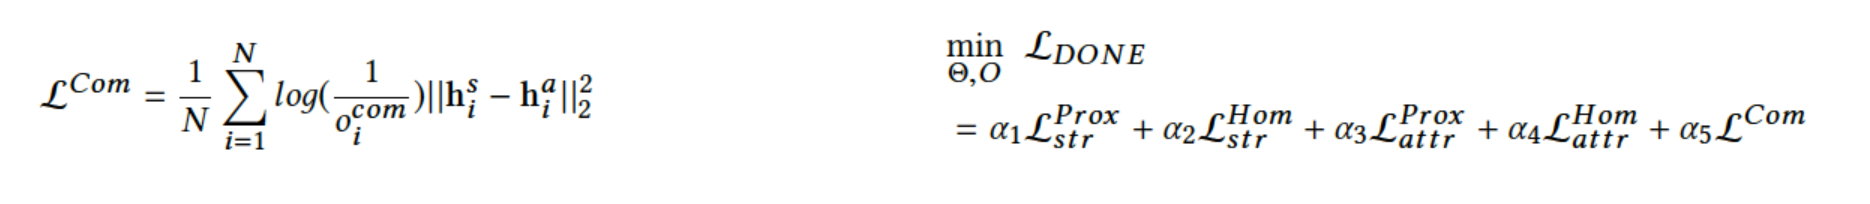


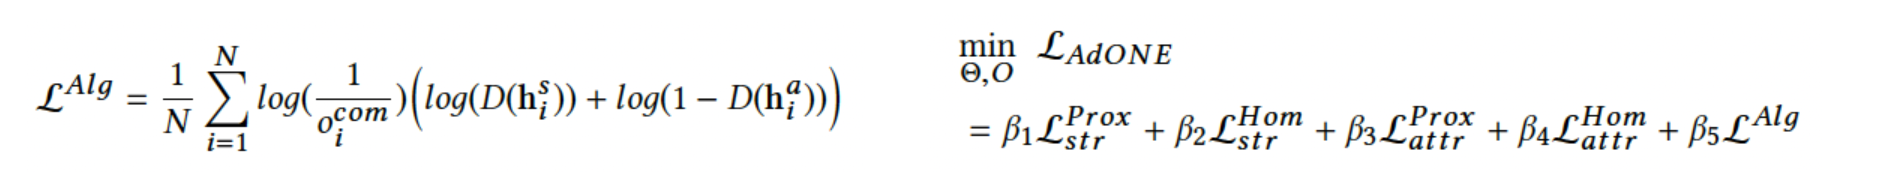

- The final anomaly score is computed as the sum of the distance between the latent representations of a node in the two autoencoders, and the reconstruction error of its attributes and adjacency matrix.

In [12]:
from Baselines.GraphUnsupervised.run import PYGOD

model_name = 'DONE'
clf = PYGOD
clf = clf(seed=seed, model_name=model_name)

for rla in rla_list[0:1]:
    data = load_data(rla)

### Uncomment to train from scratch
#     train_model(data = data, rla = rla, clf = clf, type_model='Graph', supervision='Unsupervised', model_name='DONE')
    load_pretrained_model(data = data, rla = rla, clf = clf,type_model='Graph', supervision='Unsupervised', model_name='DONE')
    test_model(data = data, rla = rla, clf = clf,type_model='Graph', supervision='Unsupervised', model_name='DONE')
    print('------------------------------------------------------------------------------------------','\n')

number of gpu: 1
cuda name: Tesla T4
GPU is on
{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.0}


Model: DONE, AUC-ROC: 0.47504599367140193, AUC-PR: 0.0120741656598884
Time inference:3938.483940601349
------------------------------------------------------------------------------------------ 



In [13]:
from Baselines.GraphUnsupervised.run import PYGOD

model_name = 'AdONE'
clf = PYGOD
clf = clf(seed=seed, model_name=model_name)

for rla in rla_list[0:1]:
    data = load_data(rla)

### Uncomment to train from scratch
#     train_model(data = data, rla = rla, clf = clf, type_model='Graph', supervision='Unsupervised', model_name='AdONE')
    load_pretrained_model(data = data, rla = rla, clf = clf,type_model='Graph', supervision='Unsupervised', model_name='AdONE')
    test_model(data = data, rla = rla, clf = clf,type_model='Graph', supervision='Unsupervised', model_name='AdONE')
    print('------------------------------------------------------------------------------------------','\n')

number of gpu: 1
cuda name: Tesla T4
GPU is on
{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.0}


Model: AdONE, AUC-ROC: 0.5365783758678828, AUC-PR: 0.013777667381056718
Time inference:2470.7121798992157
------------------------------------------------------------------------------------------ 



#### 4.2.2. Supervised Methods

**[GCN]()** 
- GCN (Graph Convolutional Neural Network) is a supervised transductive learning method designed for graph-structured data.
- It is based on an efficient variant of convolutional neural networks (CNNs) that directly operate on graphs.
- GCN learns hidden layer representations that encode both the local graph structure and the features of nodes.
- By combining information from neighboring nodes, GCN effectively captures the dependencies and relationships within the graph data.

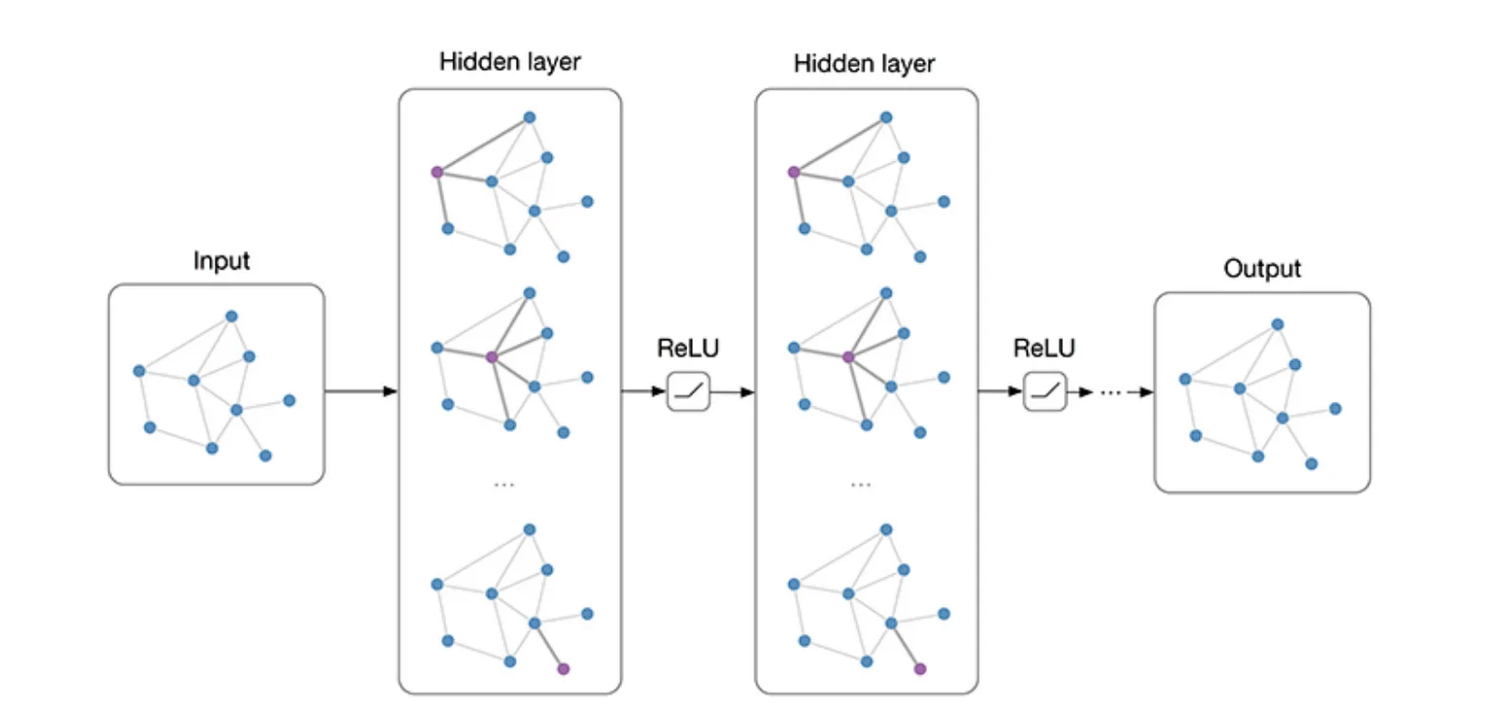

In [ ]:
from Baselines.GraphSupervised.GNN.run import GNN

model_name = 'GCN'
clf = GNN
clf = clf(seed=seed, model_name=model_name)

for rla in rla_list[1:]:
    data = load_data(rla)

### Uncomment to train from scratch
#     train_model(data = data, rla = rla, clf = clf, type_model='Graph', supervision='Supervised', model_name='GCN')
    load_pretrained_model(data = data, rla = rla, clf = clf,type_model='Graph', supervision='Supervised', model_name='GCN')
    test_model(data = data, rla = rla, clf = clf,type_model='Graph', supervision='Supervised', model_name='GCN')
    print('------------------------------------------------------------------------------------------','\n')
    

number of gpu: 1
cuda name: Tesla T4
GPU is on
cuda:0
{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.01}


Model: GCN, AUC-ROC: 0.598011358858917, AUC-PR: 0.01811903045115821
Time inference:1.3540418148040771
------------------------------------------------------------------------------------------ 

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.05}


Model: GCN, AUC-ROC: 0.638125451141152, AUC-PR: 0.021228562741334066
Time inference:0.4438457489013672
------------------------------------------------------------------------------------------ 

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.

**[SAGE]()** 
- SAGE is a general inductive framework for generating node embeddings in graph data.
- It leverages node feature information, such as text attributes, to efficiently generate embeddings even for previously unseen data.
- Instead of training individual embeddings for each node, SAGE learns a function that generates embeddings by sampling and aggregating features from a node's local neighborhood.
- By considering the feature information from neighboring nodes, SAGE captures the contextual information and relationships within the graph data.
- This approach enables the generation of embeddings for new, unseen nodes based on their feature attributes, expanding the applicability of SAGE to handle dynamic or evolving graph data.

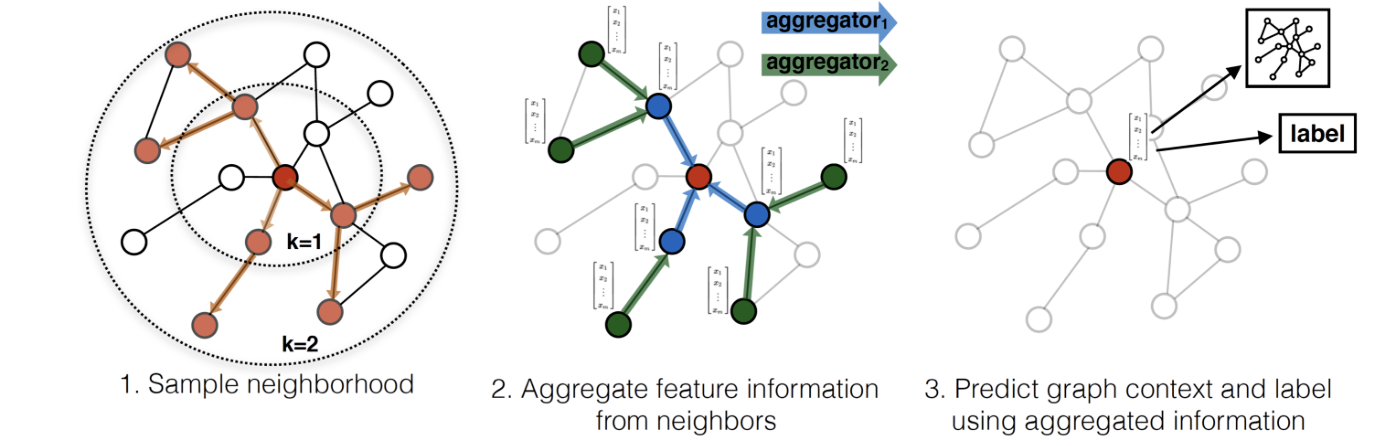

In [ ]:
from Baselines.GraphSupervised.GNN.run import GNN

model_name = 'SAGE'
clf = GNN
clf = clf(seed=seed, model_name=model_name)

for rla in rla_list[1:]:
    data = load_data(rla)

### Uncomment to train from scratch
#     train_model(data = data, rla = rla, clf = clf, type_model='Graph', supervision='Supervised', model_name='SAGE')
    load_pretrained_model(data = data, rla = rla, clf = clf, type_model='Graph', supervision='Supervised', model_name='SAGE')
    test_model(data = data, rla = rla, clf = clf, type_model='Graph', supervision='Supervised', model_name='SAGE')
    print('------------------------------------------------------------------------------------------','\n')

number of gpu: 1
cuda name: Tesla T4
GPU is on
cuda:0
{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.01}


Model: SAGE, AUC-ROC: 0.6361089427418605, AUC-PR: 0.019414031190437005
Time inference:0.4112083911895752
------------------------------------------------------------------------------------------ 

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.05}


Model: SAGE, AUC-ROC: 0.6934606618368662, AUC-PR: 0.02586447416829424
Time inference:0.4028961658477783
------------------------------------------------------------------------------------------ 

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)'

**[AMNET](https://github.com/zjunet/AMNet)**
- AMNET is one of the first supervised graph anomaly detection methods and it is based of graph signal theory:
    - Anomalies tend to have different features from the neighbors (high-frequency information). 
    - Normal nodes tend to share common features with their normal neighbors (low-frequency information).
- This characteristic conflicts with the general assumption of traditional GNNs, where they tend to smooth signals of adjacent nodes.
- It aims to capture both high frequency and low frequency signals by designing the multi-frequency filter group in order to capture graph signals of different frequencies simultaneously.
- The assumption is that abnormal nodes in a graph often activate high pass filters as they exhibit dissimilarity to their mostly normal neighbors.

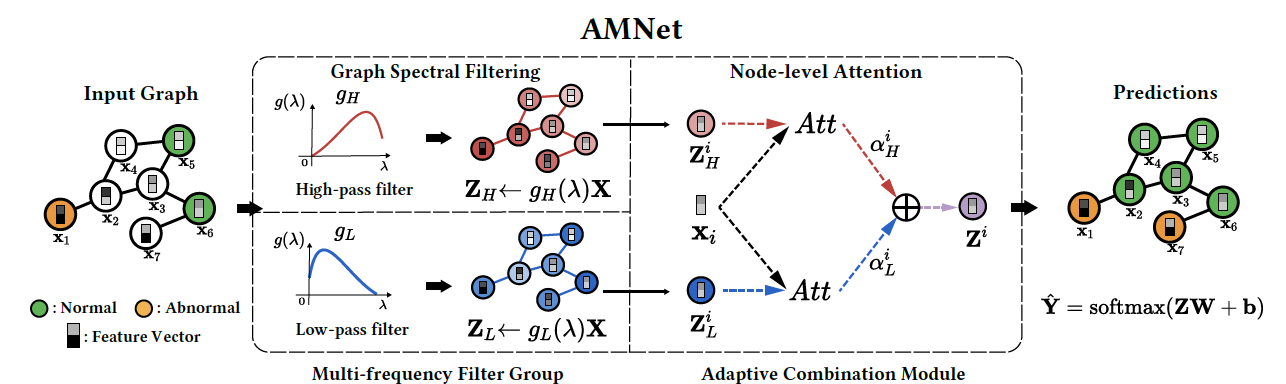

- After geting K specific signals $Z_k$ with diverse frequency properties the attention mechanism used to learn the corresponding importance (α1, ...,αk) and adaptively combine signals of different frequencies as follows:

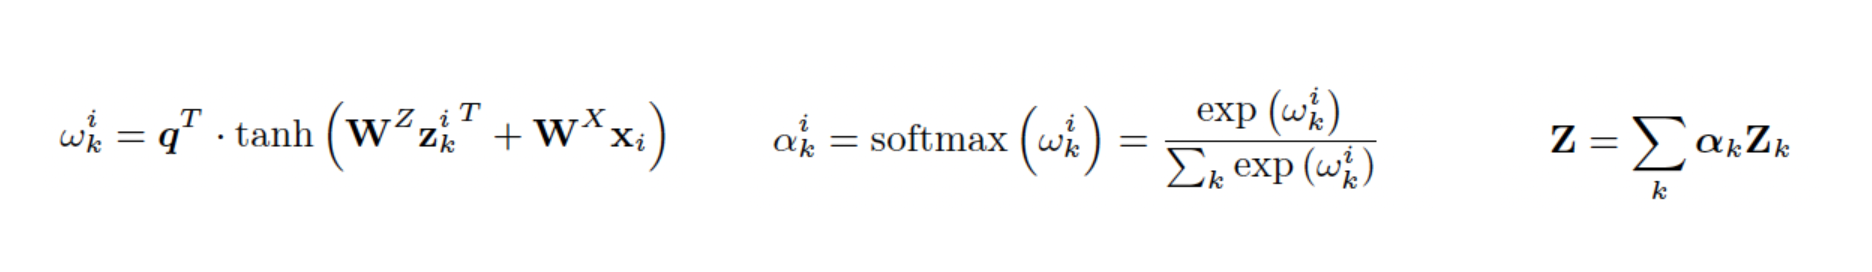


- Intuitively, to enhance the difference, anomalous nodes need to exploit more high-frequency information, they apply an additional constraint on attention training to encourage that anomalous nodes and normal nodes focus on different filters, respectively. For example, given attention values of two filters {$α_L, α_H$}, the margin based constraint on attention can be defined as bellow where $r_i$ equals to 1 if node i is anomalous and -1 otherwise:

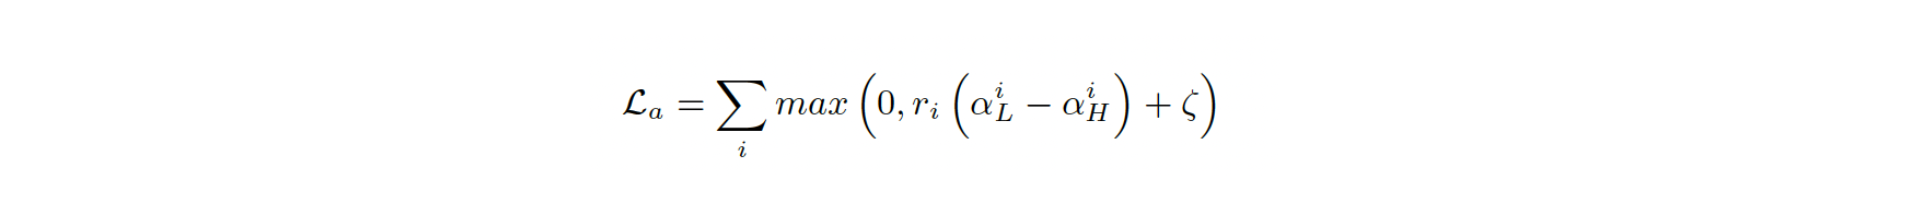

- The final objective function to predict anamoly score is a combination of the classification loss and the margin based constraint on attention.

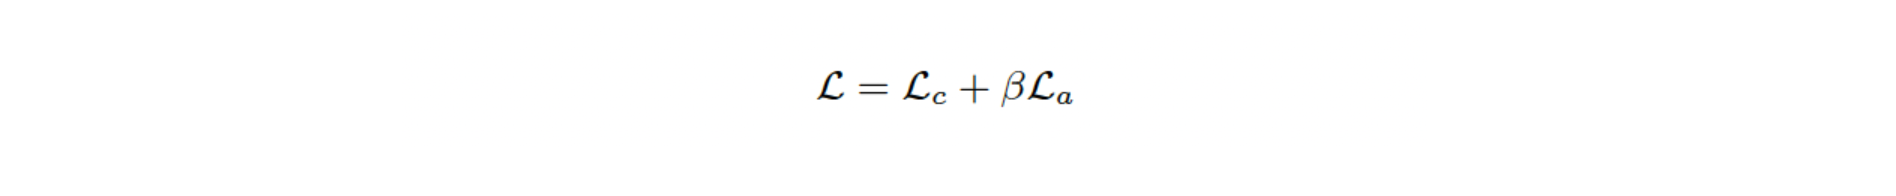

In [ ]:
from Baselines.GraphSupervised.AMNet.run import AMNet

model_name = 'AMNet'
clf = AMNet
clf = clf(seed=seed, model_name=model_name)

for rla in rla_list[1:]:
    data = load_data(rla)

### Uncomment to train from scratch
#     train_model(data = data, rla = rla, clf = clf,type_model='Graph', supervision='Supervised', model_name='AMNet')
    load_pretrained_model(data = data, rla = rla, clf = clf,type_model='Graph', supervision='Supervised', model_name='AMNet')
    test_model(data = data, rla = rla, clf = clf,type_model='Graph', supervision='Supervised', model_name='AMNet')
    print('------------------------------------------------------------------------------------------','\n')

number of gpu: 1
cuda name: Tesla T4
GPU is on
cuda:0
{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.01}


Model: AMNet, AUC-ROC: 0.6615128348979777, AUC-PR: 0.019273331344836275
Time inference:1.871333360671997
------------------------------------------------------------------------------------------ 

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%)': 0.05}


Model: AMNet, AUC-ROC: 0.6584498820094375, AUC-PR: 0.018925239314625423
Time inference:0.9224648475646973
------------------------------------------------------------------------------------------ 

{'Train Nodes': 857899, 'Validation Nodes': 183862, 'Test Nodes': 183840, 'Anomalies': '15509/1225601', 'Background Nodes': 2474949, 'Features': 17, 'Labeled Anomalies Ratio(%

<a id='section5'></a>
## 5. Results Comparision

We compare the results of our proposed methods with the baselines on the DGraphFin dataset.The results are saved as csv files in **RESULTS_PATH**. In the following we read these csv files and plot the results using **visualize** function.

`visualize:` function plots the results of the methods in four different line plots based on their supervision (supervised/unsupervised) and type (tabular/graph). It takes the name of the metric that the plot demonstrates as the **y_label** argument and plots it on the y-axis. The x-axis represents the ratio of labeled anomalies (**la_list**) in the trained data.

In [38]:
metrics= ['AUCROC','AUCPR','Time(fit)','Time(inference)']
metrics_range = [(0.3,0.8),(0,0.04),(0,8000),(0,100)]
for type_model in ['Tabular','Graph']:
    for supervision in ['Unsupervised','Supervised']:
        print(type_model,supervision)
        path = type_model + '_' + supervision + '_seed_' + str(seed)+'.csv'
        df_AUCROC[type_model][supervision] = pd.read_csv(RESULTS_PATH+'AUCROC_'+path,index_col=0)
        df_AUCROC[type_model][supervision].sort_index(axis=1)
        df_AUCPR[type_model][supervision] = pd.read_csv(RESULTS_PATH+'AUCPR_'+path,index_col=0)
        df_AUCPR[type_model][supervision].sort_index(axis=1)
        df_time_fit[type_model][supervision] = pd.read_csv(RESULTS_PATH+'time_fit_'+path,index_col=0)
        df_time_fit[type_model][supervision].sort_index(axis=1)
        df_time_inference[type_model][supervision] = pd.read_csv(RESULTS_PATH+'time_inference_'+path,index_col=0)
        df_time_inference[type_model][supervision].sort_index(axis=1)

Tabular Unsupervised
Tabular Supervised
Graph Unsupervised
Graph Supervised


In [39]:
def visualize(df,y_label,y_lim_range):
    '''
        :param df: dataframe that contains the results
        :param y_label: the metric of the intrest that we want to plot on y axis
        :param y_lim_range: the range of y axis
    '''
    ## make a plot with 4*4 subplots

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 7))

    ## make font smaller

    sns.set(font_scale=0.9)

    ## increase distance between subplots

    fig.subplots_adjust(hspace=0.25, wspace=0.25)

    i = 0
    list_df = []

    for type_model in ['Tabular','Graph']:
        list_df.append(pd.concat(list(df[type_model].values()),axis=1))
        for supervision in ['Unsupervised','Supervised']:

            ## add line plot to each subplot
            df[type_model][supervision].index= [str(rla) for rla in rla_list]

            sns.lineplot(data=df[type_model][supervision],markers=True, dashes=True,linewidth = 2,ax=axes[i])

            ## make lines narrower
            sns.set(font_scale=1)

            axes[i].set(ylim=y_lim_range)

            axes[i].set_ylabel(y_label, fontsize=15)
            axes[i].set_xlabel('Ratio of labeled anomaly', fontsize=15)
            axes[i].set_title(supervision + ' ' + type_model, fontsize=15) ## change to string formating
            i+= 1
    display(pd.concat(list_df,axis=1))

### 5.1. AUROC Visualization

,IForest,CBLOF,DeepSAD,XGB,FTTransformer,MLP,OCGNN,DONE,AdONE,GCN,SAGE,AMNet
0.00,0.528719,0.378805,NaN,NaN,NaN,NaN,0.526603,0.475046,0.536578,NaN,NaN,NaN
0.01,NaN,NaN,0.671503,0.709125,0.682869,0.657435,NaN,NaN,NaN,0.598011,0.636109,0.661513
0.05,NaN,NaN,0.704360,0.717528,0.687512,0.700412,NaN,NaN,NaN,0.638125,0.693461,0.658450
0.10,NaN,NaN,0.714919,0.720030,0.701170,0.709391,NaN,NaN,NaN,0.664385,0.709925,0.659772
0.25,NaN,NaN,0.717792,0.721519,0.714285,0.715210,NaN,NaN,NaN,0.698718,0.734295,0.661204
0.50,NaN,NaN,0.720316,0.723939,0.693099,0.716529,NaN,NaN,NaN,0.718436,0.747659,0.660722
0.75,NaN,NaN,0.724107,0.724182,0.706722,0.718274,NaN,NaN,NaN,0.726766,0.756701,0.660466
1.00,NaN,NaN,0.724388,0.723759,0.704988,0.719340,NaN,NaN,NaN,0.732937,0.761090,0.660898


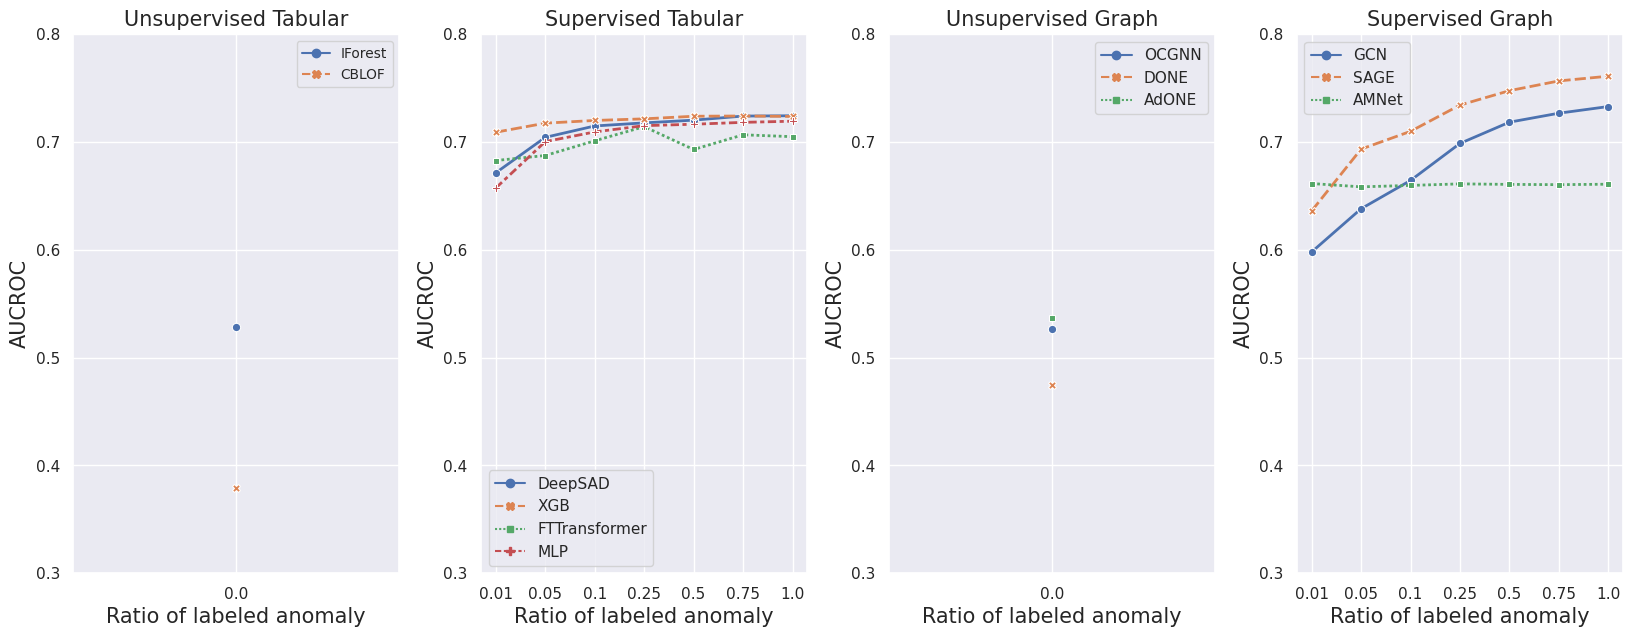

In [40]:
visualize(df_AUCROC,metrics[0],metrics_range[0])

### 5.2. AUPR Visualization

,IForest,CBLOF,DeepSAD,XGB,FTTransformer,MLP,OCGNN,DONE,AdONE,GCN,SAGE,AMNet
0.00,0.014228,0.009463,NaN,NaN,NaN,NaN,0.02114,0.012074,0.013778,NaN,NaN,NaN
0.01,NaN,NaN,0.019893,0.023823,0.020383,0.018150,NaN,NaN,NaN,0.018119,0.019414,0.019273
0.05,NaN,NaN,0.024440,0.026261,0.020354,0.022694,NaN,NaN,NaN,0.021229,0.025864,0.018925
0.10,NaN,NaN,0.025930,0.026083,0.021622,0.024760,NaN,NaN,NaN,0.023257,0.027494,0.019067
0.25,NaN,NaN,0.025977,0.026152,0.025917,0.025662,NaN,NaN,NaN,0.026409,0.032519,0.019241
0.50,NaN,NaN,0.026593,0.027647,0.021359,0.025963,NaN,NaN,NaN,0.028584,0.035465,0.019161
0.75,NaN,NaN,0.026977,0.027520,0.023203,0.026937,NaN,NaN,NaN,0.030996,0.038663,0.019124
1.00,NaN,NaN,0.026880,0.027531,0.022879,0.026933,NaN,NaN,NaN,0.033104,0.039693,0.019165


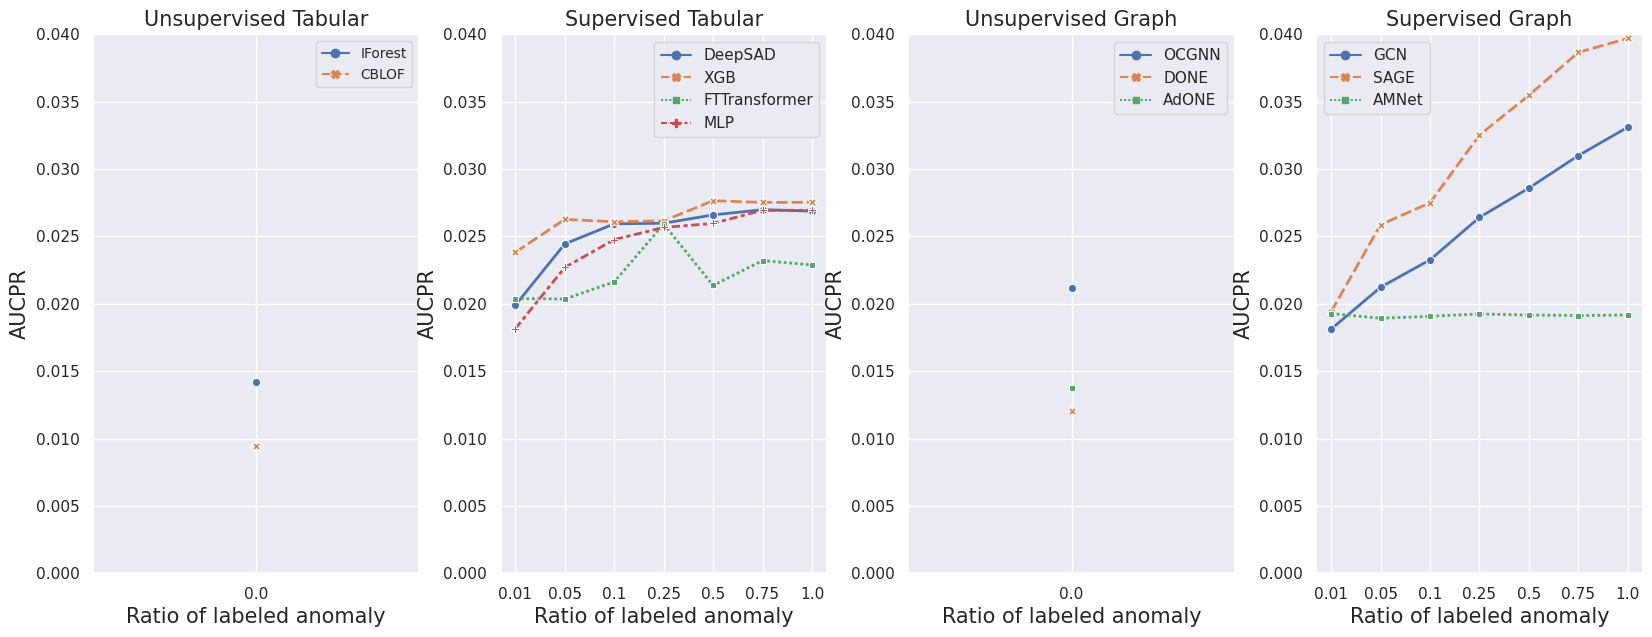

In [41]:
visualize(df_AUCPR,metrics[1],metrics_range[1])

### 5.3. Fit Time Visualization

,IForest,CBLOF,DeepSAD,XGB,FTTransformer,MLP,OCGNN,DONE,AdONE,GCN,SAGE,AMNet
0.00,75.765942,38.045596,NaN,NaN,NaN,NaN,37397.417886,3538.582861,3930.62239,NaN,NaN,NaN
0.01,NaN,NaN,7642.044045,61.346125,12572.007489,269.523329,NaN,NaN,NaN,123.555845,250.596296,96.637341
0.05,NaN,NaN,7645.295828,77.808614,12776.685589,261.052460,NaN,NaN,NaN,223.490494,240.918721,102.230909
0.10,NaN,NaN,7706.477087,77.563317,12828.625506,265.137849,NaN,NaN,NaN,222.413118,239.646032,99.241538
0.25,NaN,NaN,7638.888483,81.957833,12779.047941,263.373487,NaN,NaN,NaN,223.958570,240.743674,93.685996
0.50,NaN,NaN,7620.301060,83.733522,12956.911626,268.831089,NaN,NaN,NaN,224.435354,242.291434,99.827969
0.75,NaN,NaN,7776.061470,84.744118,12967.486523,267.546024,NaN,NaN,NaN,224.718724,240.089591,102.466806
1.00,NaN,NaN,7840.148168,83.321556,12886.849259,261.536043,NaN,NaN,NaN,224.308313,238.315642,102.596355


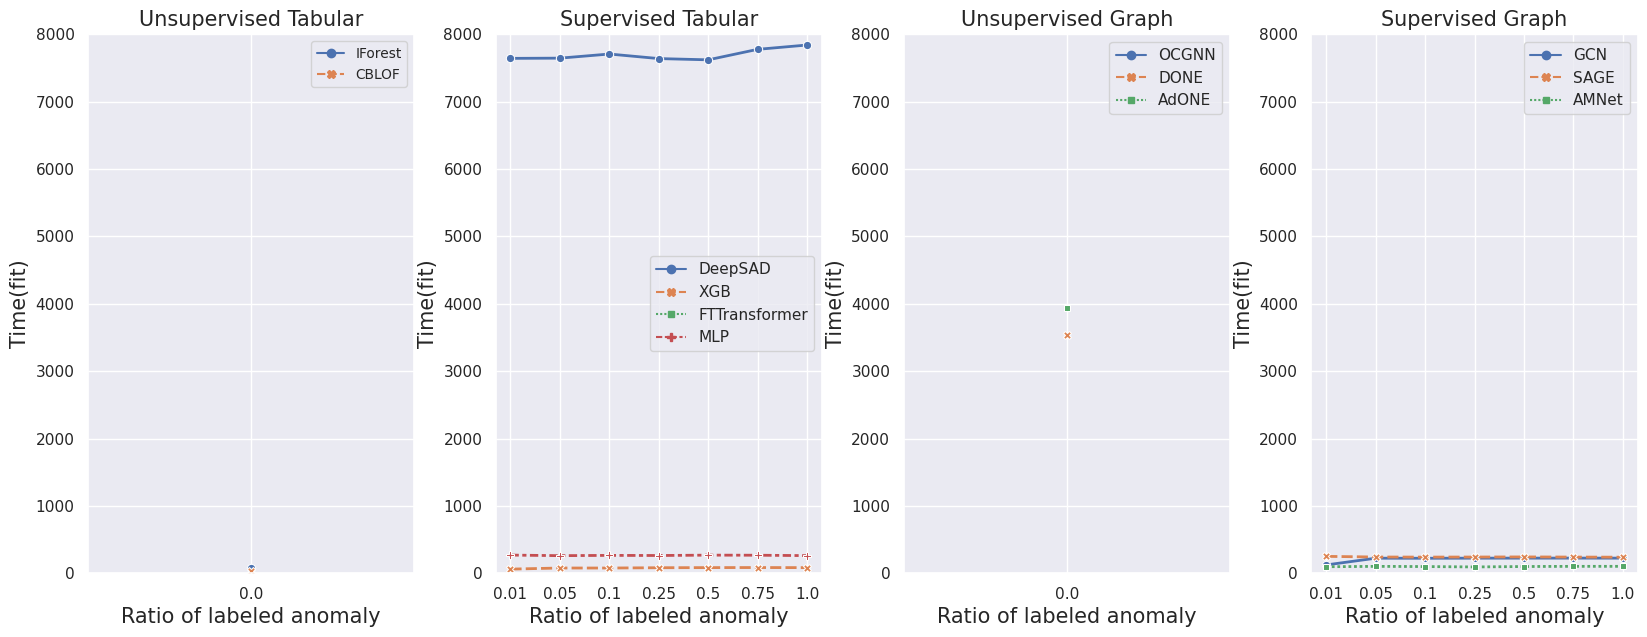

In [42]:
visualize(df_time_fit,metrics[2],metrics_range[2])

### 5.4. Inference Time Visualization

,IForest,CBLOF,DeepSAD,XGB,FTTransformer,MLP,OCGNN,DONE,AdONE,GCN,SAGE,AMNet
0.00,6.30483,1.435657,NaN,NaN,NaN,NaN,71.973063,3938.483941,2470.71218,NaN,NaN,NaN
0.01,NaN,NaN,6.367088,0.705161,3.453011,0.181314,NaN,NaN,NaN,0.257698,0.281300,0.817982
0.05,NaN,NaN,6.345222,0.729487,3.507039,0.275282,NaN,NaN,NaN,0.262035,0.282004,0.819956
0.10,NaN,NaN,6.338612,0.780747,3.540332,0.200715,NaN,NaN,NaN,0.262511,0.285034,0.817187
0.25,NaN,NaN,6.368698,0.871894,3.561394,0.181553,NaN,NaN,NaN,0.262599,0.281534,0.825876
0.50,NaN,NaN,6.329712,0.910999,3.580956,0.186715,NaN,NaN,NaN,0.264033,0.281730,0.829218
0.75,NaN,NaN,6.423478,0.961959,3.581810,0.264465,NaN,NaN,NaN,0.265730,0.279523,0.819532
1.00,NaN,NaN,6.202979,0.982454,3.560658,0.176702,NaN,NaN,NaN,0.265512,0.280075,0.829758


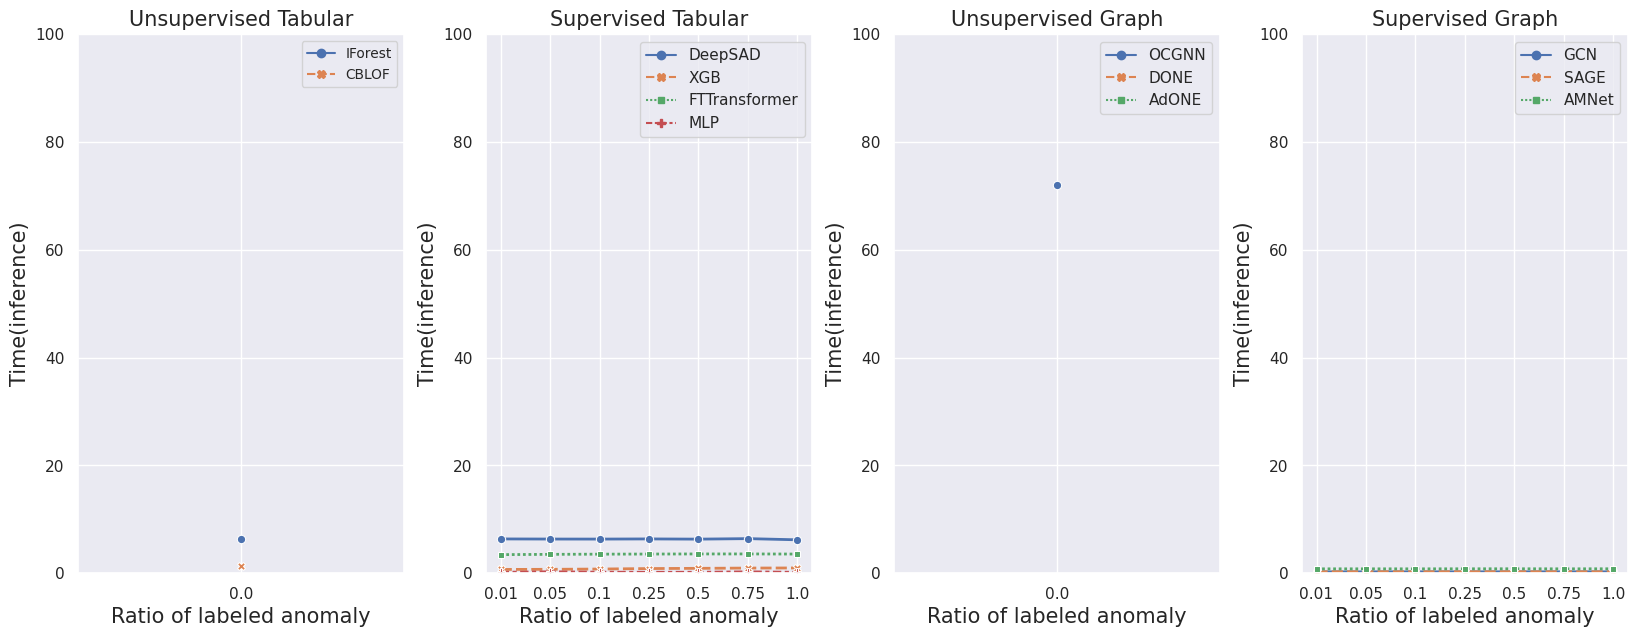

In [43]:
visualize(df_time_inference,metrics[3],metrics_range[3])

### 5.5. Takeaways

Here we will summarise crucial takeaways from the results of the experiments:

- **Performace observations**

    - **AUCROC is higher than AUCPR:**  A higher AUCROC suggests that the model tends to have a higher false positive rate compared to the true positive rate. This means that there may be a larger number of normal samples classified as anomalies. However, a higher AUCROC indicates that the model is still effective at detecting most anomalies.

    - **All supervised methods are better than unsupervised methods:** The superiority of supervised methods over unsupervised methods is due to the availability of additional information in supervised learning. Supervised methods can utilize labels to train the model more effectively. In contrast, unsupervised methods only have access to the graph structure and node attributes without using the labels.

    - **All graph supervised methods are better than tabular supervised methods:** Graph supervised methods outperform tabular supervised methods because graph data provides more comprehensive information for training the model. The graph structure enables the model to capture additional relationships and dependencies among data points, leading to improved performance. In tabular data, only the node attributes are available, limiting the ability to utilize the graph structure.

    - **All graph unsupervised methods have comparative performance with tabular unsupervised methods:** Graph unsupervised methods have comparable performance to tabular unsupervised methods because they only rely on node attributes and do not leverage the graph structure or labels of the data. This indicates the effectiveness of labels in leveraging the graph structure for anomaly detection.

- **Time observations**

    - **Deep learning supervised methods have faster inference time but more training time compared to others**

    - **Unsupervised graph methods have the worst inference and train time**

    - **XGBoost and AMNET has the fastest training time among supervised methods**

- **Categorical observations**

    - **Tabular unsupervised methods**
        - IForest outperforms CBLOF in terms of performance.
        - CBLOF exhibits faster training and inference times compared to iForest.

    - **Tabular supervised methods**
        - XGBoost stands out as the top-performing and most consistent tabular method across various ratios of labeled anomalies.
        - XGBoost exhibits the shortest training time among the compared tabular methods.
        - DeepSAD shows slightly superior performance compared to MLP and FTTransformer in cases with lower ratios of labeled anomalies.
        - FFTTransformer demonstrates longer training times compared to other tabular methods.
        - DeepSAD has the highest inference time among the evaluated tabular methods.

    - **Graph unsupervised methods**
        - OCGNN shows comparable performance to AdONE.
        - AdONE outperforms DONE due to its approach of adversarial training, which reduces the discrimination between node attributes and adjacency matrix instead of forcing them to be similar.

    - **Graph supervised methods**
        - SAGE exhibits the best performance among the methods evaluated.
        - In a fully supervised setting, general supervised graph classification methods generally outperform specific supervised graph anomaly detection methods designed specifically for anomaly detection.
        - AMNET demonstrates the most consistent performance among all the supervised methods.
        - General supervised graph classification methods, such as GCN and SAGE, are particularly sensitive to the ratio of labeled anomalies.
        - AMNET has the shortest training time and longer inference time compared to other supervised methods.
        - SAGE and GCN have similar training and inference times.

        

